# NN on sum of all pixels

In [1]:
import numpy as np
from matplotlib import pylab as plt

In [2]:
import src.operate_datasets    as operate_datasets
import src.model_visualisation as model_visualisation
import src.model_evaluation    as model_evaluation

Welcome to JupyROOT 6.18/00


## Load data

In [3]:
full_X, full_y = operate_datasets.load_dataset('~/snd_data/new_dataset/', 'longitudal')

X_train, y_train, _, _ = operate_datasets.split_dataset(full_X, full_y)

In [4]:
X_train.shape

(108000, 13)

In [5]:
#X_train = X_train.reshape(-1, 1)
#y_train = y_train.reshape(-1, 1)

In [6]:
#min_clip = 500
#X_train_clp, y_train_clp = operate_datasets.clip_dataset(X_train, y_train, min_clip)
X_train_clp, y_train_clp = X_train, y_train

## Fit model

In [7]:
import torch
from torch import nn
from torch.distributions import constraints

#import pyro
#import pyro.distributions as dist
#from pyro.nn import PyroModule

from torch.optim.lr_scheduler import ReduceLROnPlateau

In [8]:
X_tens = torch.tensor(X_train_clp).float()
y_tens = torch.tensor(y_train_clp).float()

In [9]:
X_tens.shape

torch.Size([108000, 13])

In [10]:
def train_iteration(model, optimizer, loss_fn, x_data, y_data):
    y_pred = model(x_data).squeeze(-1)
    loss = loss_fn(y_pred, y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [11]:
class NN(nn.Module):
    def __init__(self, hid_num):
        super().__init__()
        self.fc1 = nn.Linear(13, hid_num)
        self.fc2 = nn.Linear(hid_num, 1)

    def forward(self, x, y=None):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [12]:
def run_training(num_iter):
    model = NN(32) # PyroModule[nn.Linear](1, 1)
    loss_fn = torch.nn.MSELoss(reduction='sum')
    
    loss_arr  = []

    optim = torch.optim.Adam(model.parameters(), lr=0.01)
    #scheduler = ReduceLROnPlateau(optim, 'min', factor=0.1, patience=25, verbose=True)

    for j in range(num_iter):
        loss = train_iteration(model, optim, loss_fn, X_tens, y_tens)

        if (j + 1) % 50 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))
            
        #scheduler.step(loss)
        loss_arr.append(loss.item())
        
    return model, loss_arr

In [13]:
model, loss_arr = run_training(300)

[iteration 0050] loss: 44199.0430
[iteration 0100] loss: 3435.8757
[iteration 0150] loss: 2722.1328
[iteration 0200] loss: 2582.5420
[iteration 0250] loss: 2523.2031
[iteration 0300] loss: 2500.3501


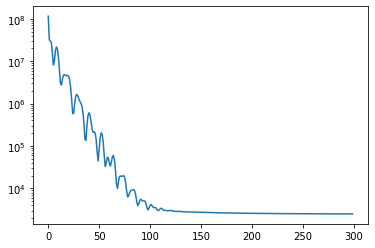

In [14]:
plt.plot(loss_arr)
plt.yscale('log')
plt.show()

In [23]:
y_pred = model(torch.Tensor(X_train)).detach().cpu().numpy().squeeze(-1)

In [24]:
y_pred

array([0.30170536, 0.1409013 , 0.47166443, ..., 0.21403778, 0.2824807 ,
       0.23953038], dtype=float32)

## Visualise results

In [38]:
X_sum = X_train.sum(axis=1).reshape(-1,1)

In [39]:
y_train = y_train.reshape(-1,1)
y_pred = y_pred.reshape(-1,1)

In [40]:
model_name = 'NN on sum'

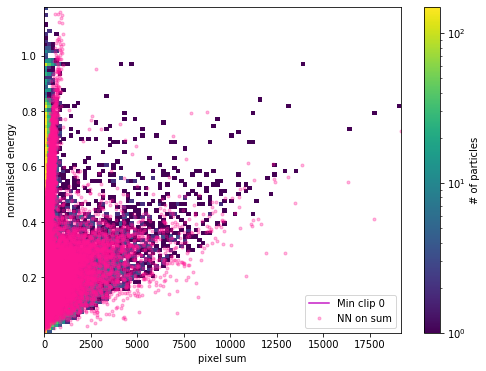

In [41]:
model_visualisation.plot_2d_energy_hist_clip(X_sum, y_train, y_pred, 0, model_name) 

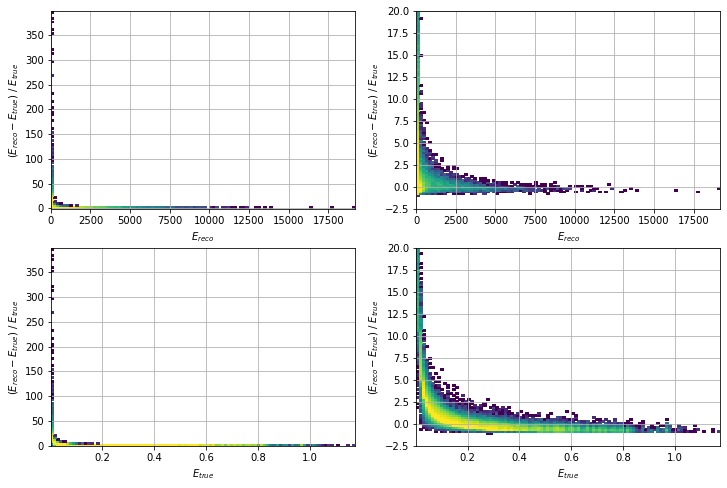

In [42]:
model_visualisation.plot_res_vs_energy(X_sum, y_train, y_pred, vmax=450) 

mean   = 1.49382e+00
std    = 5.84185e+00
median = 2.88495e-01


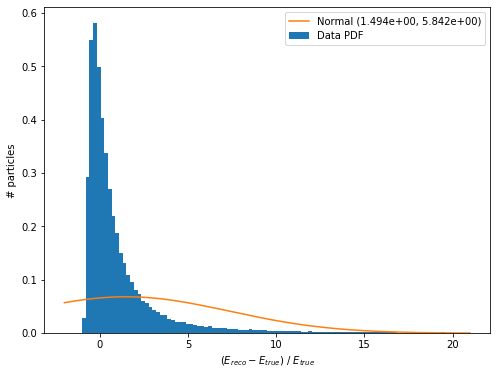

In [43]:
model_visualisation.plot_res_hist_fit(y_train, y_pred, [-1,20])

In [44]:
model_evaluation.get_scores(y_train, y_pred)

explained_variance_score 0.2764287043906457
max_error 1.0353066757294378
mean_absolute_error 0.11332876704474704
mean_squared_error 0.023149035719042844
mean_squared_log_error 0.013579078418443493
median_absolute_error 0.09257749310930571
r2_score 0.2764286417316151


{'explained_variance_score': 0.2764287043906457,
 'max_error': 1.0353066757294378,
 'mean_absolute_error': 0.11332876704474704,
 'mean_squared_error': 0.023149035719042844,
 'mean_squared_log_error': 0.013579078418443493,
 'median_absolute_error': 0.09257749310930571,
 'r2_score': 0.2764286417316151}